#Théorie

On considère un ensemble de données $(x_i)_{i\in[1,N]}$ tiré selon une mixture gaussienne de paramètres $(\theta_i, \mu_i, \Sigma_i)_{i\in[1,G]}$.
On définit les vecteurs aléatoires $(z_i)_{i\in[1,N]}$ par :
$$
(z_i)_j = P(x_i|x_i\sim N(\mu_j, \Sigma_j))
$$
On définit C comme :
$$
C_{i,j} = W2( N(\mu_i, \Sigma_i), N(\mu_j, \Sigma_j))
$$
dont on connaît la forme explicite.
<br>
On se propose de définir une distance $d$ sur les $(x_i)$ de la manière suivante :
$$
d(x_i, x_j) = W2(z_i, z_j, C)
$$

P10 : Wasserstein GMM


In [ ]:
%cd 'drive/My Drive/Optimal Transport/Project'

/content/drive/My Drive/Optimal Transport/Project


In [ ]:
!pip install POT

In [ ]:
import numpy as np
import sklearn.datasets
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.linalg import sqrtm
import ot
from tqdm.notebook import tqdm

In [ ]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
def confidence_ellipse(mu, sigma, ax, n_std=3.0, facecolor='none', **kwargs):
    pearson = sigma[0, 1]/np.sqrt(sigma[0, 0] * sigma[1, 1])
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0,0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)
    scale_x = np.sqrt(sigma[0, 0]) * n_std
    mean_x = mu[0]
    
    scale_y = np.sqrt(sigma[1, 1]) * n_std
    mean_y = mu[1]
    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    ax.add_patch(ellipse)

In [ ]:
class DummyTopicModel:
  def __init__(self, nb_components, nb_dimensions, nb_realizations, sigma_magnitude):
    self.nb_components = nb_components
    self.nb_dimensions = nb_dimensions
    self.sigma_magnitude = sigma_magnitude

    theta = np.random.rand(nb_components)
    self.theta = theta/np.sum(theta)

    mus = (np.random.rand(nb_components, nb_dimensions))
    row_sums = mus.sum(axis=1)
    self.mus = mus / row_sums[:, np.newaxis]

    self.sigmas = np.array([sigma_magnitude*sklearn.datasets.make_spd_matrix(nb_dimensions) for k in range(nb_components)])

  def draw_real(self, W=2000):
    

  def histogram_representation(self, documents, n_montecarlo = 1000):
    hist_repr = []

    model = GaussianMixture(n_components = self.nb_components)
    model.means_ = self.mus
    model.covariances_ = self.sigmas
    model.precisions_cholesky_ = np.linalg.inv(self.sigmas)

    for document in documents:
      model.weights_ = document
      X, labels = model.sample(n_montecarlo)
      X_mean = np.mean(X, axis=0)
      hist_repr.append((X_mean)/np.sum(X_mean))
    return np.array(hist_repr)
  
  def display_documents(self, documents, repr='topic', mode='truncate', color=None, show_theta=False, show_average=False, label='Documents'):
    docs_repr = documents[:,:]
    if repr=='hist':
      docs_repr = self.histogram_representation(docs_repr)
    if mode=='truncate':
      plt.scatter(docs_repr[:,0], docs_repr[:,1], marker='x', label=label, alpha=0.7, c=color)
    elif mode == 'tsne':
      plt.xticks([], [])
      plt.yticks([], [])
      tsne = TSNE(n_components=2)
      docs_repr_2d = tsne.fit_transform(np.concatenate(([self.theta], docs_repr)))
      plt.scatter(docs_repr_2d[1:,0], docs_repr_2d[1:,1], label=label, c = color)
      if show_theta:
        plt.scatter(docs_repr_2d[0,0], docs_repr_2d[0,1], label='$\\theta$')
      if show_average:
        plt.scatter(np.mean(docs_repr_2d[1:,0]), np.mean(docs_repr_2d[1:,1]), marker='s', label='Average')
      return docs_repr_2d[1:]
    return docs_repr

  
  def display_GMM(self, ax):
    for i in range(len(self.mus)):
      c=np.random.rand(3,)
      confidence_ellipse(self.mus[i,:2], self.sigmas[i,:2, :2],ax, edgecolor=c)
      ax.scatter(self.mus[i,0], self.mus[i,1], color=c)


In [ ]:
model = DummyTopicModel(12, 20, 1e-5)

In [ ]:
nb_majors = 3
def make_major(mus, sigmas, theta, mu_factor=0.8, sigma_factor=2, theta_factor=3):
  mus_mean = np.repeat(np.mean(mus, axis=0).reshape(-1,1), len(mus), axis=1).T
  mus = (1-mu_factor)*mus + mu_factor*mus_mean
  sigmas *= sigma_factor
  theta *= theta_factor
  return mus, sigmas, theta
model.mus[:nb_majors], model.sigmas[:nb_majors], model.theta[:nb_majors] = make_major(model.mus[:nb_majors], model.sigmas[:nb_majors], model.theta[:nb_majors])
model.sigmas[nb_majors:] /= 7
model.theta/=np.sum(model.theta)

In [ ]:
class DocumentGenerator:
  def __init__(self, alpha):
    self.alpha = alpha
    self.nb_components = alpha.shape[0]

  def draw(self, nb_documents):
    return np.random.dirichlet(self.alpha, (nb_documents))

In [ ]:
sigma = 1
doc_gen = DocumentGenerator(model.theta/sigma)
documents = doc_gen.draw(200)

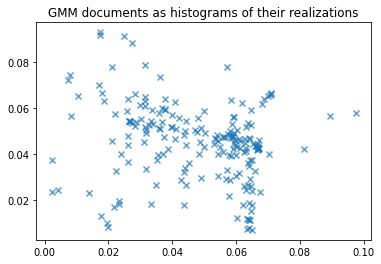

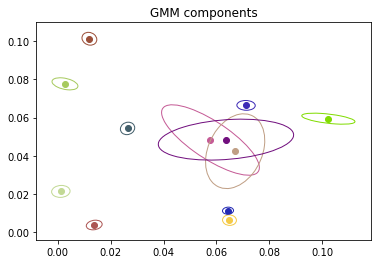

In [ ]:
plt.title('GMM documents as histograms of their realizations')
doc_repr = model.display_documents(documents, repr='hist')
plt.show()
fig, ax = plt.subplots()
plt.title('GMM components')
model.display_GMM(ax)
plt.show()

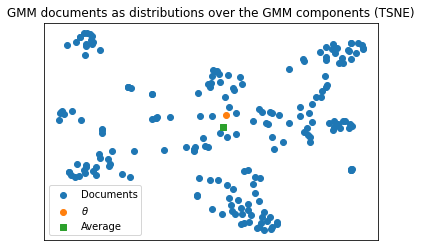

In [ ]:
plt.title('GMM documents as distributions over the GMM components (TSNE)')
model.display_documents(documents, repr='topic', mode='tsne', show_average=True, show_theta=True)
plt.legend()
plt.show()

In [ ]:
def W2_Gaussian(mu_1, sigma_1, mu_2, sigma_2):
  d_sq = np.linalg.norm(mu_1 - mu_2 ,2)**2
  sqrt_sig_1 = sqrtm(sigma_1)
  sqrt_term =  2*sqrtm((sqrt_sig_1.dot(sigma_2).dot(sqrt_sig_1)))
  d_sq += np.trace(sigma_1+sigma_2-sqrt_term)
  return d_sq**0.5

In [ ]:
class MetaDistanceGMM:
  def __init__(self, model):
    self.model = model
    self.nb_components = model.nb_components
    self.nb_dimensions = model.nb_dimensions

    self.C = np.zeros((self.nb_components, self.nb_components))
    
    for i in range(self.nb_components):
      for j in range(i):
        W2_d = W2_Gaussian(model.mus[i], model.sigmas[i], model.mus[j], model.sigmas[j])
        self.C[i,j] = W2_d
        self.C[j,i] = W2_d

  def dist(self, doc_a, doc_b):
    P = ot.emd(doc_a, doc_b, self.C)
    return np.sqrt(np.sum(P*self.C)), P

  def display_C(self):
    plt.imshow(self.C)
    plt.colorbar()
    plt.show()

  def plot_seed_dist(self, documents):
    seed_id = np.random.randint(0, len(documents))
    seed_doc = documents[seed_id]
    colors = []
    Ps = []
    for i in range(len(documents)):
      d, P = self.dist(seed_doc, documents[i])
      colors.append(d)
      Ps.append(P)
    doc_repr = self.model.display_documents(documents, repr='topic', mode='tsne', color=colors, label=None)
    plt.scatter(doc_repr[seed_id, 0],doc_repr[seed_id, 1], c = 'r', label='Seed document')
    plt.legend()
    plt.colorbar()
    return colors, np.array(Ps), seed_id, doc_repr
  
  def plot_seed_wmd_dist(self, documents, seed_id, docs_tsne):
    gmm_model = GaussianMixture(n_components = self.model.nb_components)
    gmm_model.means_ = self.model.mus
    gmm_model.covariances_ = self.model.sigmas
    gmm_model.weights_ = self.model.theta
    gmm_model.precisions_cholesky_ = np.linalg.inv(self.model.sigmas)
    words, labels = gmm_model.sample(self.model.nb_dimensions)

    C_wmd = np.zeros((self.nb_dimensions, self.nb_dimensions))
    
    for i in range(self.nb_dimensions):
      for j in range(i):
        l2_d = np.linalg.norm(words[i] - words[j])
        C_wmd[i,j] = l2_d
        C_wmd[j,i] = l2_d

    docs_repr = self.model.histogram_representation(documents)
    #seed_id = np.random.randint(0, len(documents))
    seed_doc = docs_repr[seed_id]
    colors = []
    Ps = []
    for i in range(len(docs_repr)):
      P = ot.emd(seed_doc, docs_repr[i], C_wmd)
      d = np.sqrt(np.sum(P*C_wmd))
      colors.append(d)
      Ps.append(P)

    plt.imshow(C_wmd)
    plt.colorbar()
    plt.show()
    plt.xticks([], [])
    plt.yticks([], [])
    plt.scatter(docs_tsne[:,0],docs_tsne[:,1], c=colors, label=None)
    plt.scatter(docs_tsne[seed_id, 0],docs_tsne[seed_id, 1], c = 'r', label='Seed document')
    plt.legend()
    plt.colorbar()
    return colors, np.array(Ps)

In [ ]:
meta_distance = MetaDistanceGMM(model)

In [ ]:
bow_df

,0,1,2
0,1,118,1
1,1,285,1
2,1,1229,1
3,1,1688,1
4,1,2068,1
...,...,...,...
3710415,39861,18448,1
3710416,39861,18848,1
3710417,39861,23449,1
3710418,39861,25721,1


In [ ]:
import pandas as pd

bow_df = pd.read_csv('docword.kos.txt', skiprows=3, delimiter=' ', header=None)
nb_words = np.max(bow_df[1])
nb_docs = 2000
bows = np.zeros((nb_docs, nb_words))
for i in range(len(bow_df)):
  if bow_df[0][i]<nb_docs:
    bows[bow_df[0][i]-1, bow_df[1][i]-1] += bow_df[2][i]
  else:
    break

In [ ]:
for i in range(len(bows)):
  S = np.sum(bows[i])
  if S>0:
    bows[i] = bows[i]/S

In [ ]:
def ratio_i_u(w1, w2):
  bool1 = w1>0
  bool2 = w2>0
  inter = np.sum(np.logical_and(bool1, bool2))
  union = np.sum(np.logical_or(bool1, bool2))
  return inter/union

In [ ]:
a = np.array([0,0,0])
b = np.array([0,0,0])
ratio_i_u(a,b)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in long_scalars
  


nan

In [ ]:
n_samples = 500
bows_ids = np.arange(bows.shape[0])
R = []
for _ in range(n_samples):
  a, b = np.random.choice(bows_ids, 2, replace = False)
  w_a = bows[a]
  w_b = bows[b]
  R.append(ratio_i_u(w_a,w_b))

Text(0, 0.5, 'Frequency')

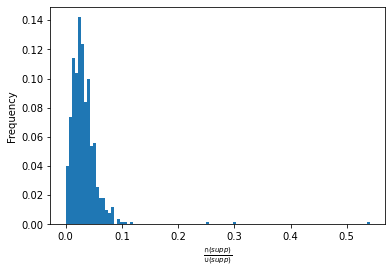

In [ ]:
plt.hist(R, bins = 100, weights = np.ones(len(R))/len(R))
plt.xlabel('$\\frac{\\cap (supp)}{\\cup (supp)}$')
plt.ylabel('Frequency')

In [ ]:
np.mean(R)

0.03311878419092792

In [ ]:
nb_words

28102

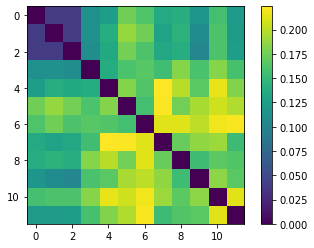

In [ ]:
meta_distance.display_C()

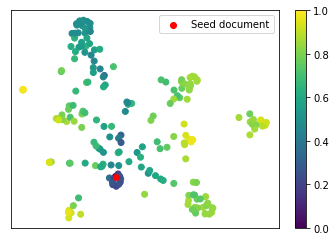

In [ ]:
d, P_sparsity, seed_id, docs_repr = meta_distance.plot_seed_dist(documents)
plt.show()

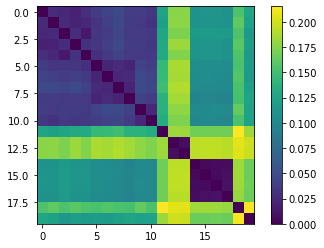

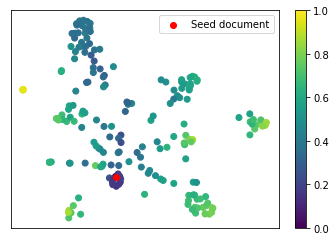

In [ ]:
meta_distance.plot_seed_wmd_dist(documents, seed_id, docs_repr)
plt.show()

In [ ]:
import cvxpy as cp

def rwmd_solver(a,b,C):
  n,m = C.shape
  u = np.ones((m,1))
  v = np.ones((n,1))
  P1 = cp.Variable((n,m))
  U1 = [0 <= P1, cp.matmul(P1,u)==a.reshape(-1,1)]
  objective1 = cp.Minimize( cp.sum(cp.multiply(P1,C)) )
  prob1 = cp.Problem(objective1, U1)
  result1 = prob1.solve()

  P2 = cp.Variable((n,m))
  U2 = [0 <= P2, cp.matmul(P2.T,v)==b.reshape(-1,1)]
  objective2 = cp.Minimize( cp.sum(cp.multiply(P2,C)) )
  prob2 = cp.Problem(objective2, U2)
  result2 = prob2.solve()

  if result1 > result2:
    return result1, P1.value
  else:
    return result2, P2.value



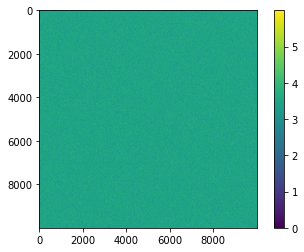

In [ ]:
n_words = 10000
C_rand = np.zeros((n_words, n_words))
    
for i in range(n_words):
  for j in range(i):
    d = np.random.random()
    C_rand[i,j] = 1+5*d
    C_rand[j,i] = 1+5*d
plt.imshow(C_rand)
plt.colorbar()

In [ ]:
def gen_dist(support, dim):
  dist = np.zeros(dim)
  for i in range(len(support)):
    dist[i] = np.random.random()
  dist = dist / np.sum(dist)
  return dist

In [ ]:
len_doc = 150
avail_words_i = np.random.choice(range(n_words), 2*len_doc, replace=False)

1.0


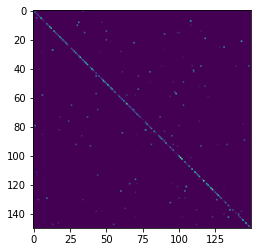

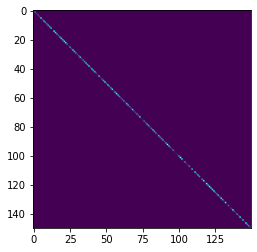

0.5789473684210527


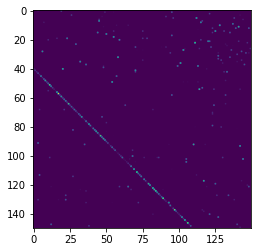

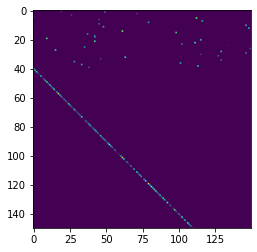

0.30434782608695654


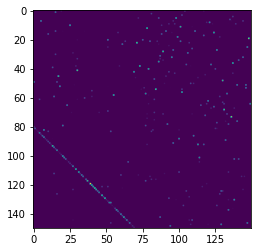

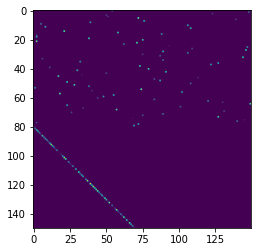

0.1111111111111111


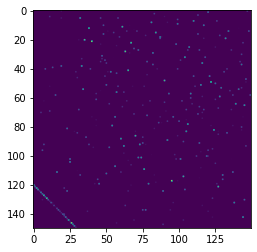

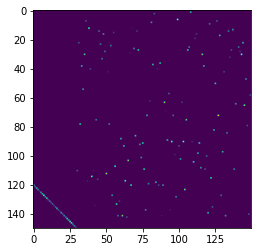

In [ ]:
ratio = []
support = []
a = gen_dist(avail_words_i[:len_doc], len_doc)
for n_diff_words in tqdm(range(len_doc)):
  b = gen_dist(avail_words_i[n_diff_words:n_diff_words+len_doc], len_doc)
  C_rand_trunc = C_rand[:,avail_words_i[n_diff_words:n_diff_words+len_doc]][avail_words_i[:len_doc]]
  support.append((len_doc - n_diff_words)/(len_doc+n_diff_words))
  P_wmd = ot.emd(a, b, C_rand_trunc)
  d_wmd = np.sqrt(np.sum(P_wmd*C_rand_trunc))
  d_rwmd, P_rwmd = rwmd_solver(a,b,C_rand_trunc)
  ratio.append(d_rwmd/d_wmd)
  if n_diff_words % 40 == 0:
    print(support[n_diff_words])
    plt.imshow(P_wmd)
    plt.show()
    plt.imshow(P_rwmd)
    plt.show()

In [ ]:
from scipy.interpolate import interp1d
f = interp1d(support, ratio)

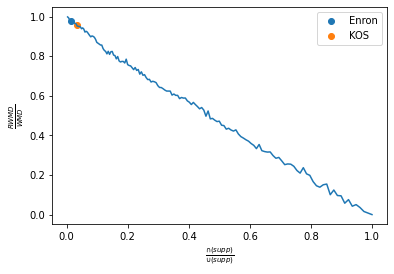

In [ ]:
plt.plot(support, ratio)
plt.xlabel('$\\frac{\\cap (supp)}{\\cup (supp)}$')
plt.ylabel('$\\frac{RWMD}{WMD}$')
plt.scatter([0.013], f(0.013), label='Enron')
plt.scatter([0.033], f(0.033), label='KOS')
plt.legend()
plt.show()

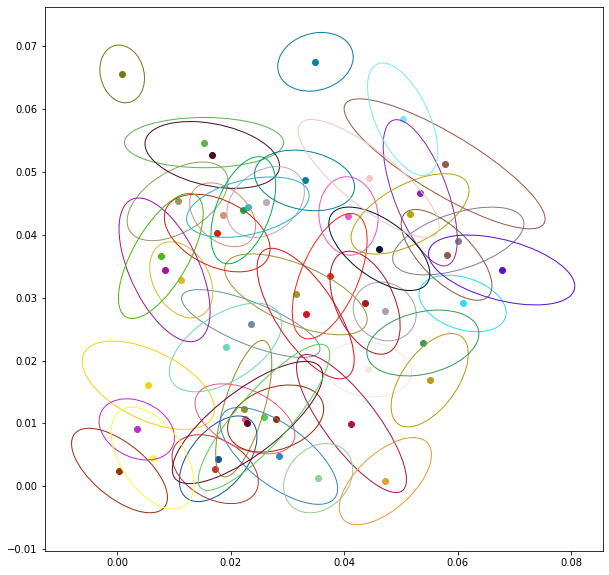

In [ ]:
plot_gmm_2d(mu,sigma)

In [ ]:
from scipy.linalg import sqrtm

C = np.zeros((nb_components, nb_components))
for i in range(nb_components):
  for j in range(nb_components):
    if i == j:
      C[i,j] = 0
    else:
      d_sq = np.linalg.norm(mu[i] - mu[j] ,2)**2
      sqrt_sig_i = sqrtm(sigma[i])
      sqrt_term =  2*sqrtm((sqrt_sig_i.dot(sigma[j]).dot(sqrt_sig_i)))
      d_sq += np.trace(sigma[i]+sigma[j]-sqrt_term)
      C[i,j] = d_sq**0.5


In [ ]:
print(C)

[[0.         0.12614236 0.1554059  ... 0.1337477  0.14398508 0.15682774]
 [0.12614236 0.         0.16170431 ... 0.16511405 0.16367482 0.15554538]
 [0.1554059  0.16170431 0.         ... 0.15022242 0.16193207 0.17490575]
 ...
 [0.1337477  0.16511405 0.15022242 ... 0.         0.15066925 0.14795555]
 [0.14398508 0.16367482 0.16193207 ... 0.15066925 0.         0.16932095]
 [0.15682774 0.15554538 0.17490575 ... 0.14795555 0.16932095 0.        ]]


In [ ]:
nb_documents = 200
documents = np.random.rand(nb_documents, nb_components)
row_sums = documents.sum(axis=1)
documents = documents / row_sums[:, np.newaxis]

In [ ]:
import ot

T=ot.emd(documents[0],documents[20],C)
W2_d=ot.emd2(documents[0],documents[20],C)

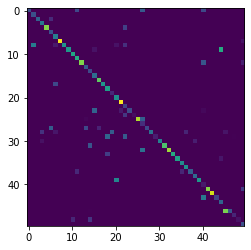

In [ ]:
plt.imshow(T)

In [ ]:
W2_d

0.03664522079653117

In [ ]:
np.linalg.norm(documents[0]-documents[20], ord = 2)

0.10224145985855439

In [ ]:
import time

nb_tests = 200
tests = np.random.choice(nb_documents, nb_tests, replace=False)
ratios = []
W2_times = []
l2_times = []
for test in tests:
  k=test
  l=k
  while l==k:
    l = np.random.randint(0, nb_documents)
  start = time.time()
  W2 = ot.emd2(documents[k],documents[l],C)
  end = time.time()
  W2_times.append(end-start)
  start=time.time()
  l2 = np.linalg.norm(documents[k]-documents[l], ord = 2)
  end = time.time()
  l2_times.append(end-start)
  ratios.append(W2/l2)

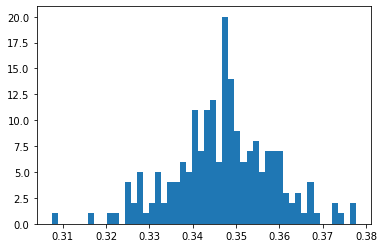

In [ ]:
plt.hist(ratios, bins=50)
plt.show()

In [ ]:
np.mean(W2_times)

0.00038763880729675293

In [ ]:
np.mean(l2_times)

1.6590356826782225e-05

In [ ]:
from tqdm import tqdm

seed = 49
w2_dists = []
w2_dists_by_label = [[] for i in range(nb_components)]
l2_dists = []
l2_dists_by_label = [[] for i in range(nb_components)]

for i in tqdm(range(nb_documents)):
  D = ot.emd2(documents[i],documents[seed],C)
  w2_dists.append(D)
  w2_dists_by_label[labels[i]].append(D)
  D_l2 = np.linalg.norm(documents[i]-documents[seed],ord=2)
  l2_dists.append(D_l2)
  l2_dists_by_label[labels[i]].append(D_l2)
  

100%|██████████| 200/200 [00:00<00:00, 2254.32it/s]


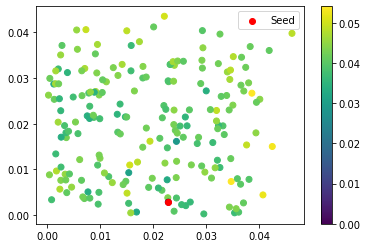

In [ ]:
plt.scatter(documents[:,0],documents[:,1], c=w2_dists)
plt.colorbar()
plt.scatter(documents[seed,0],documents[seed,1], c='red', label='Seed')
plt.legend()
plt.show()

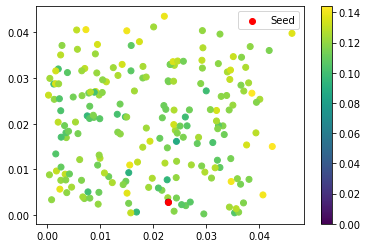

In [ ]:
plt.scatter(documents[:,0],documents[:,1], c=l2_dists)
plt.colorbar()
plt.scatter(documents[seed,0],documents[seed,1], c='red', label='Seed')
plt.legend()
plt.show()

In [ ]:
%matplotlib inline

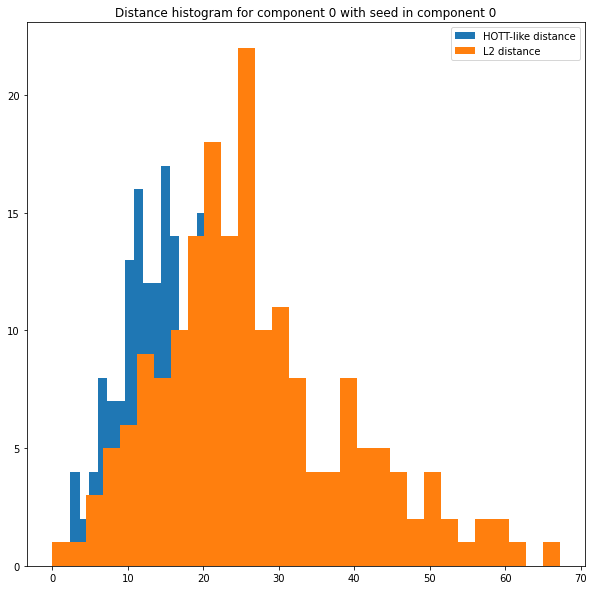

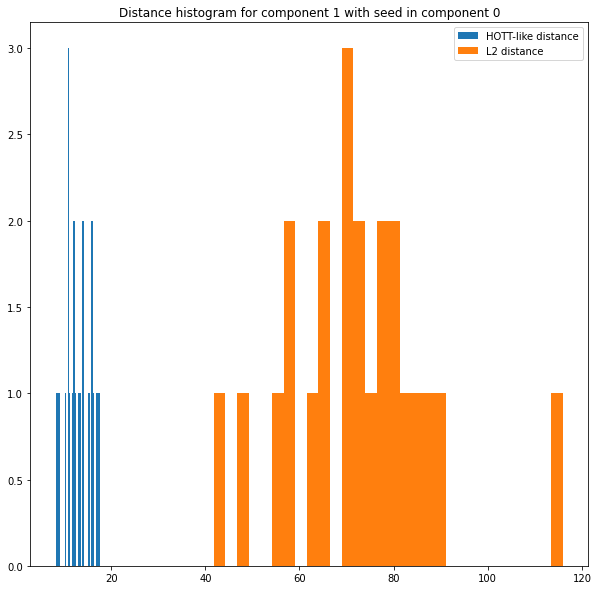

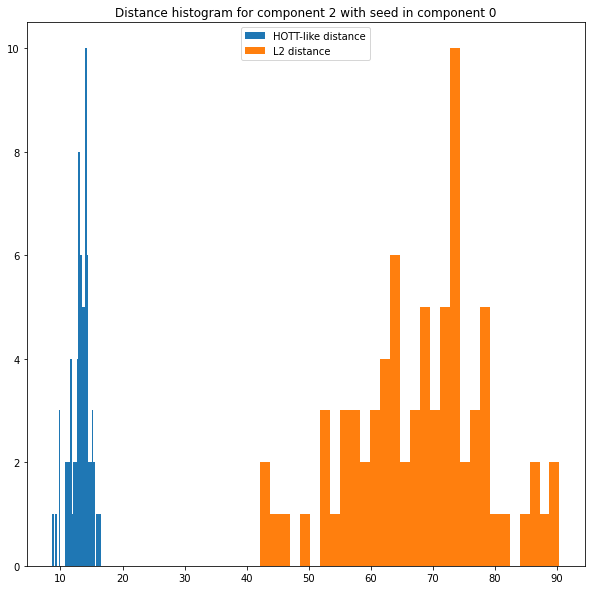

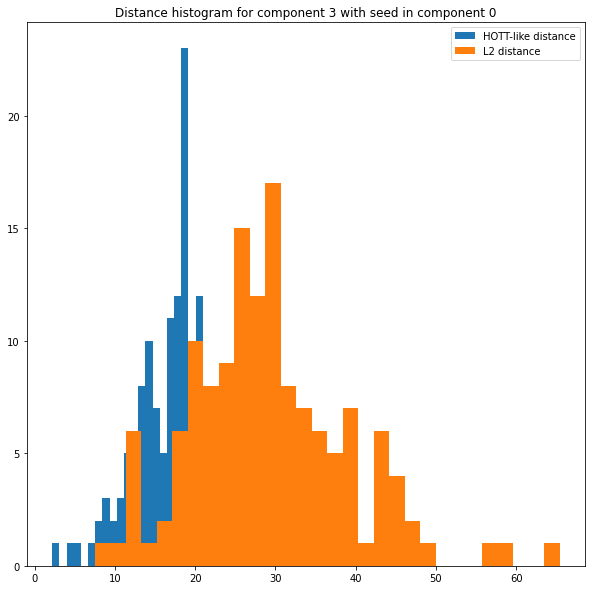

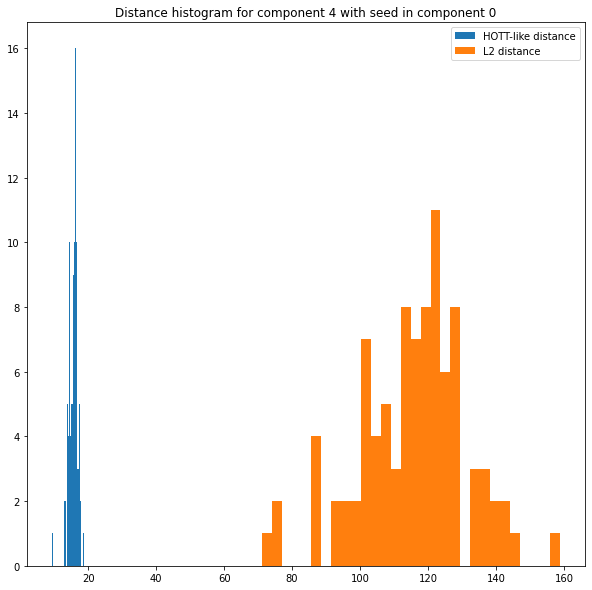

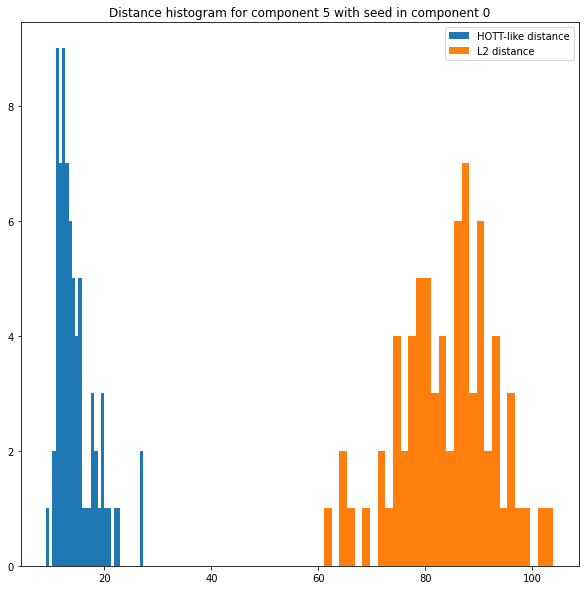

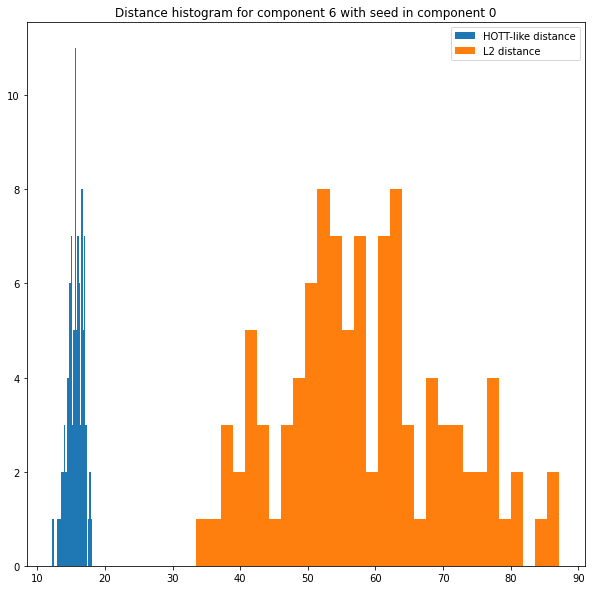

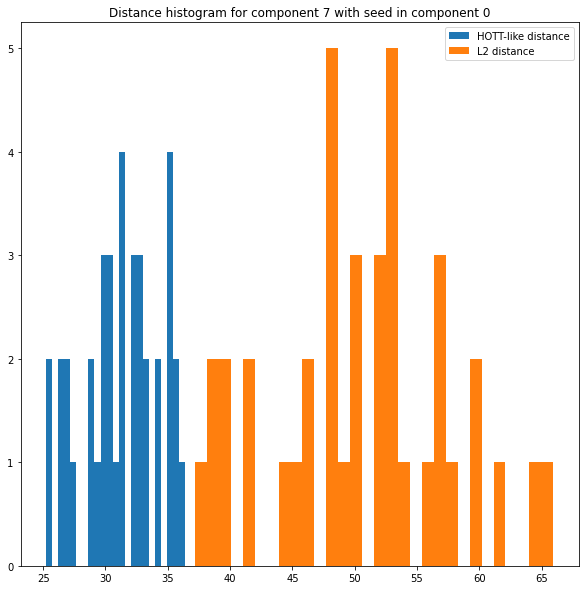

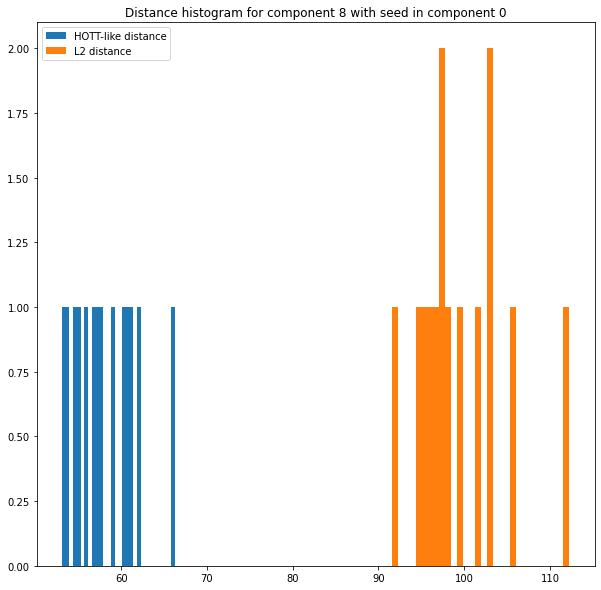

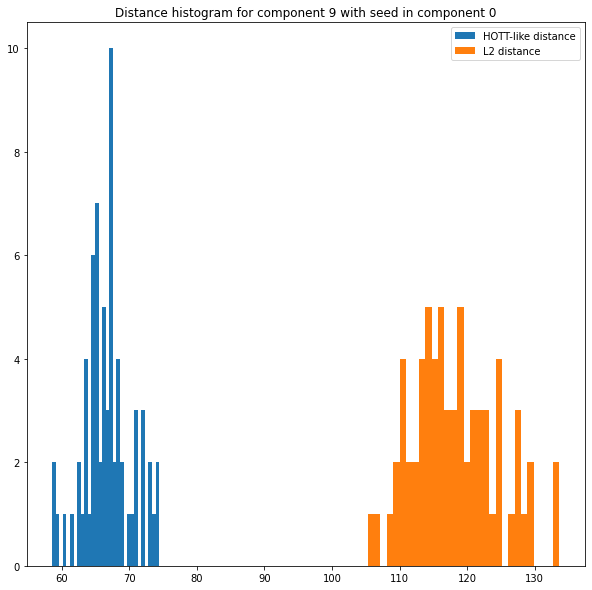

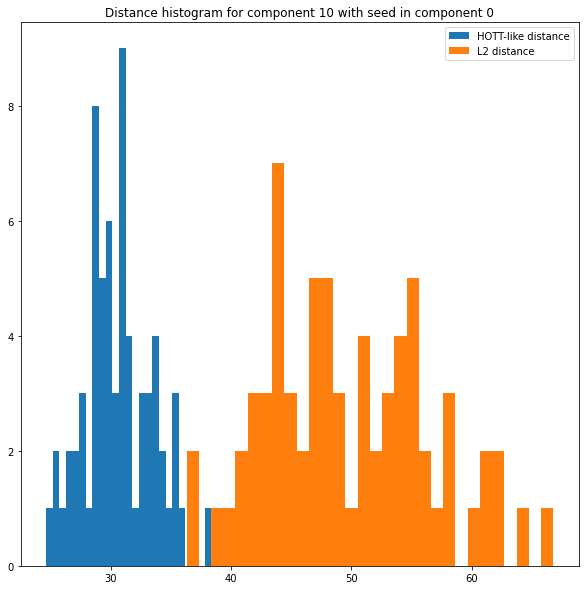

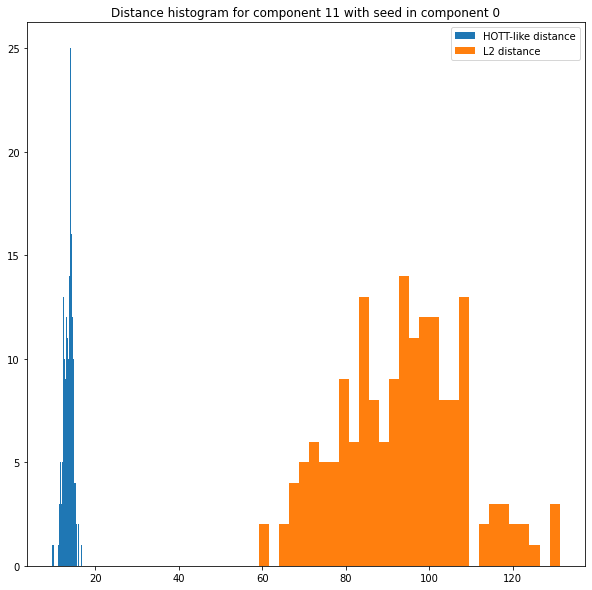

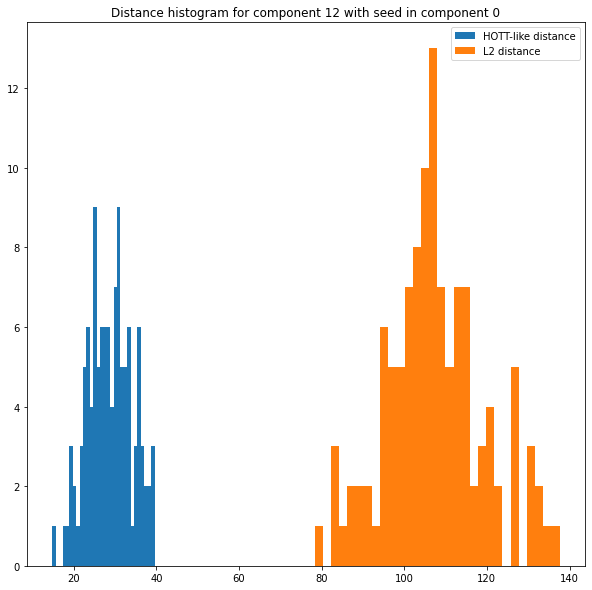

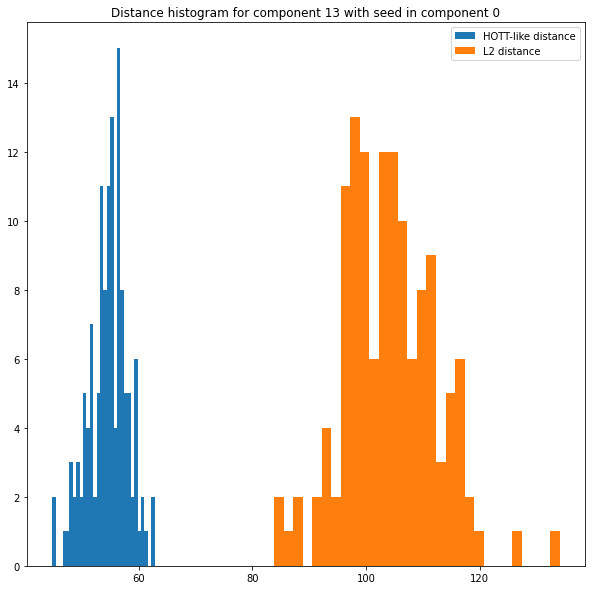

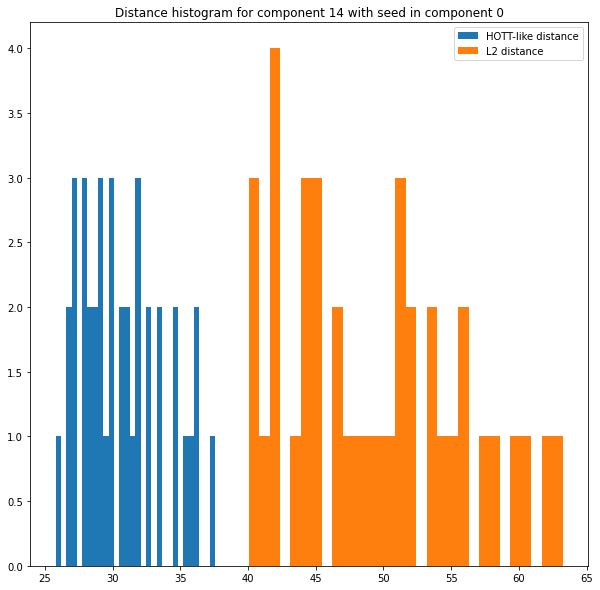

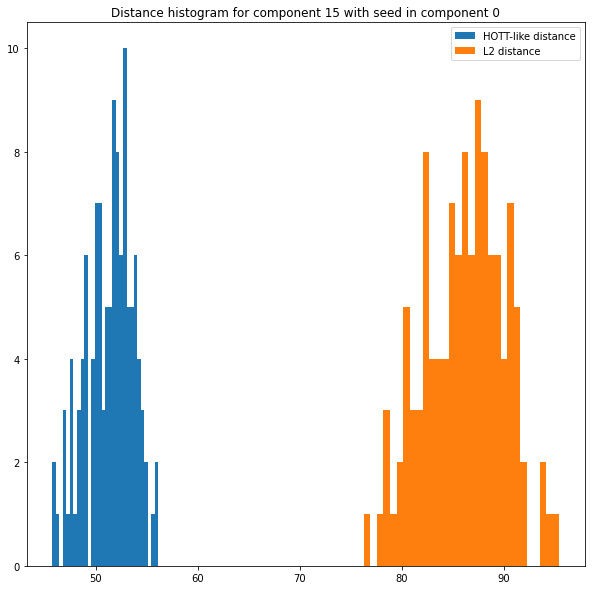

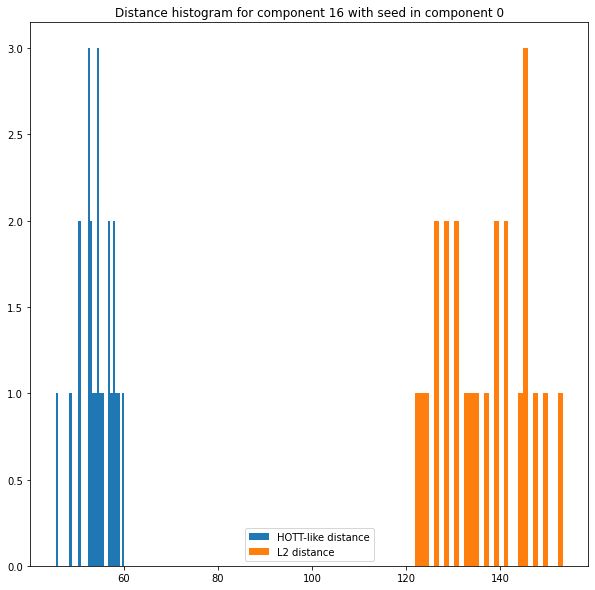

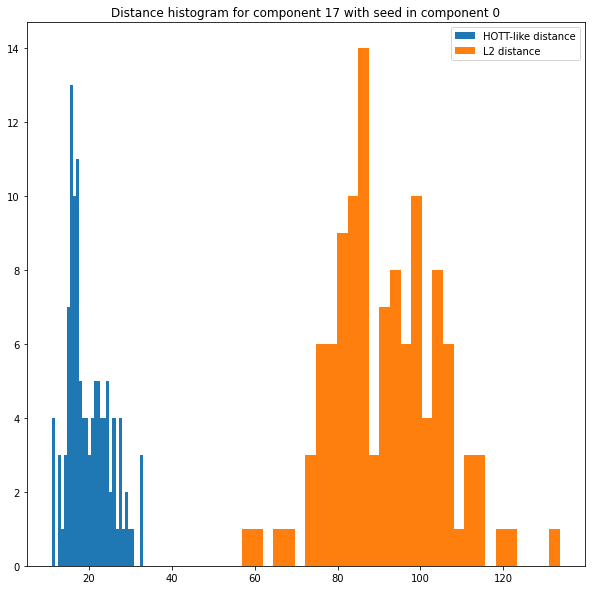

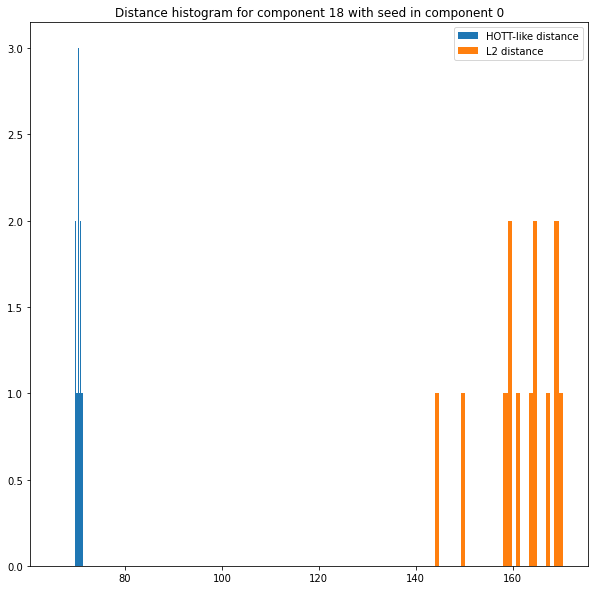

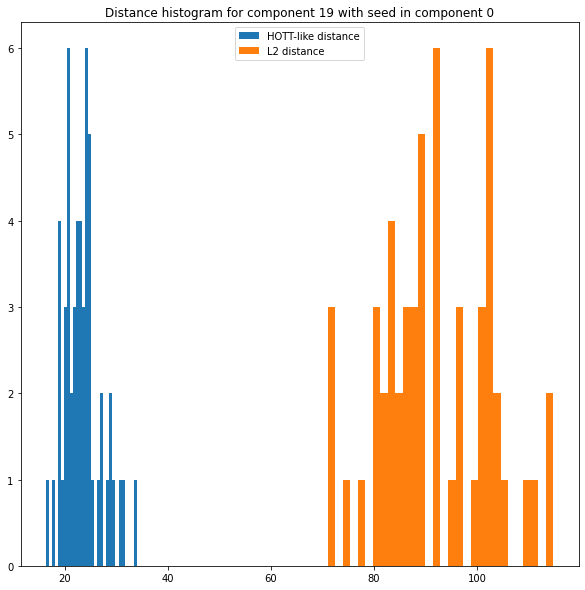

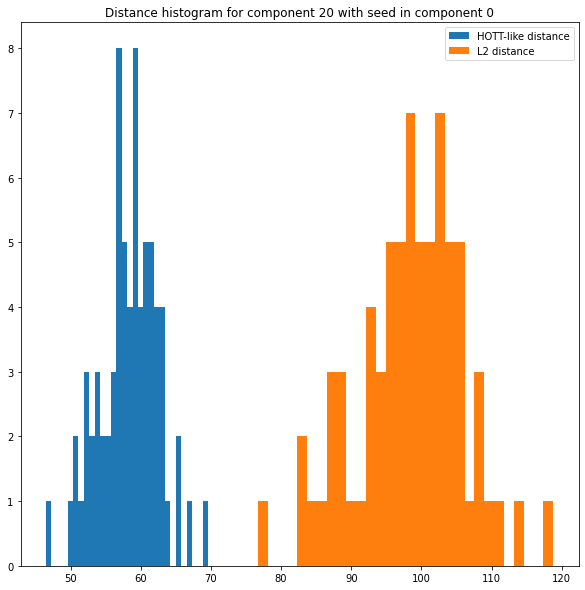

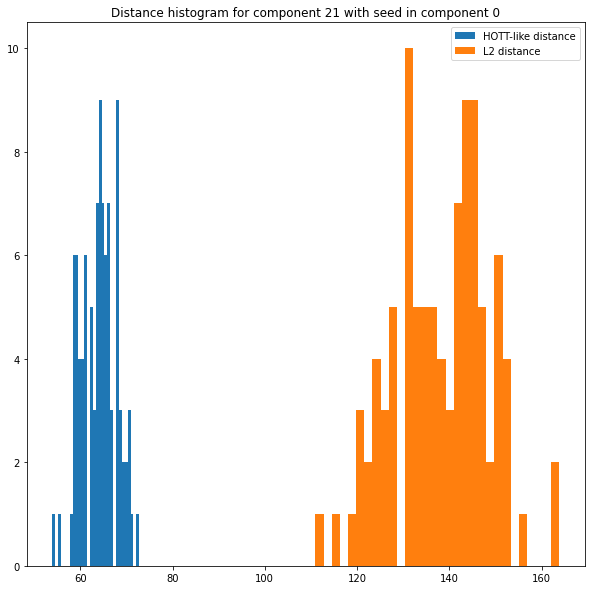

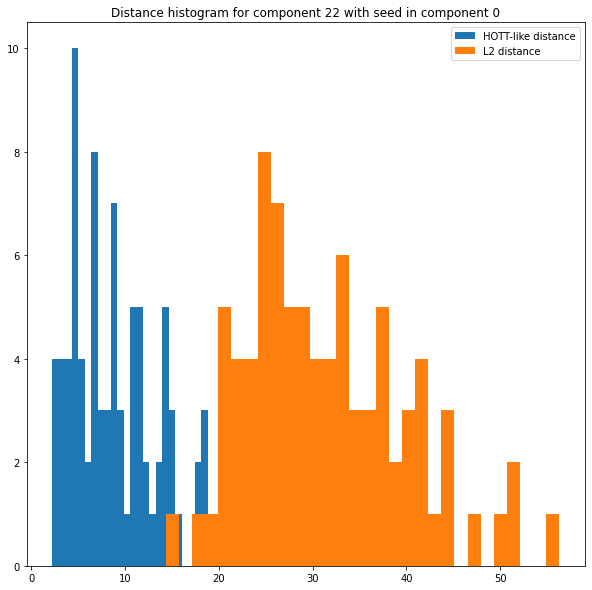

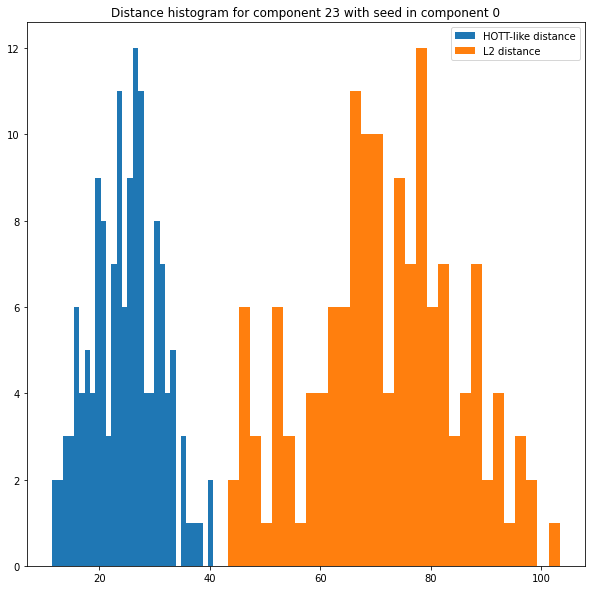

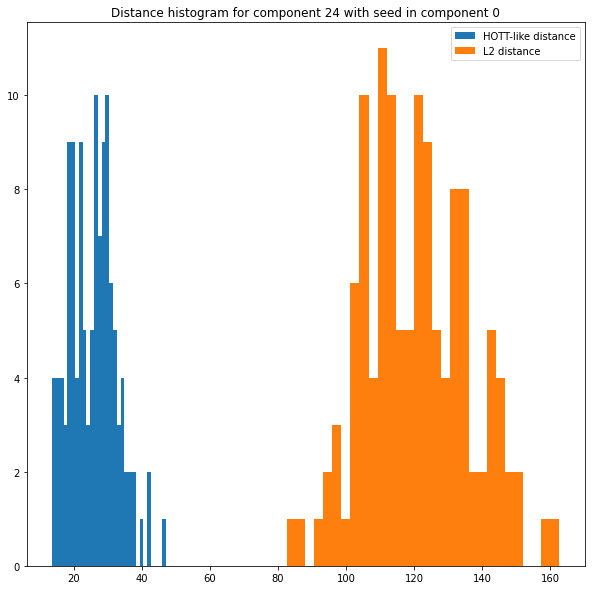

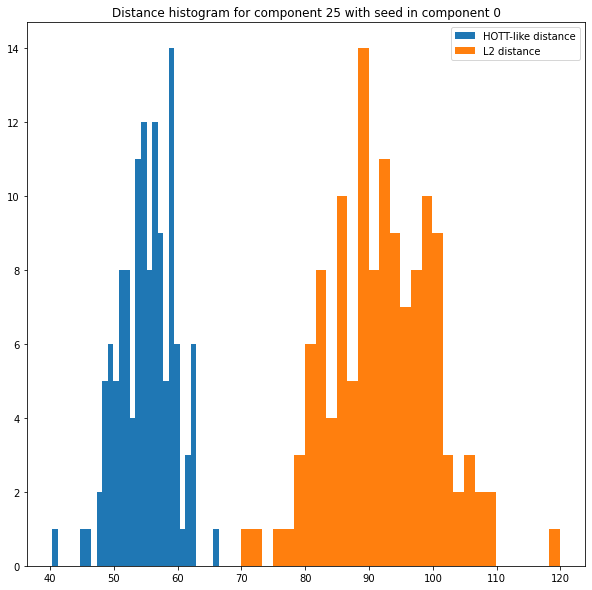

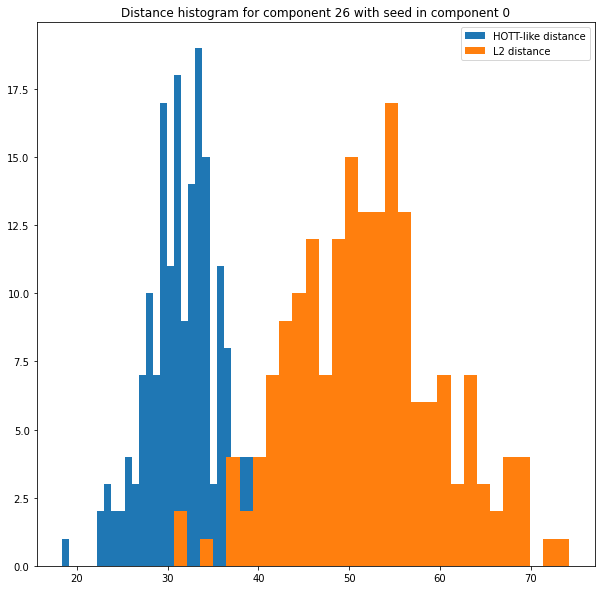

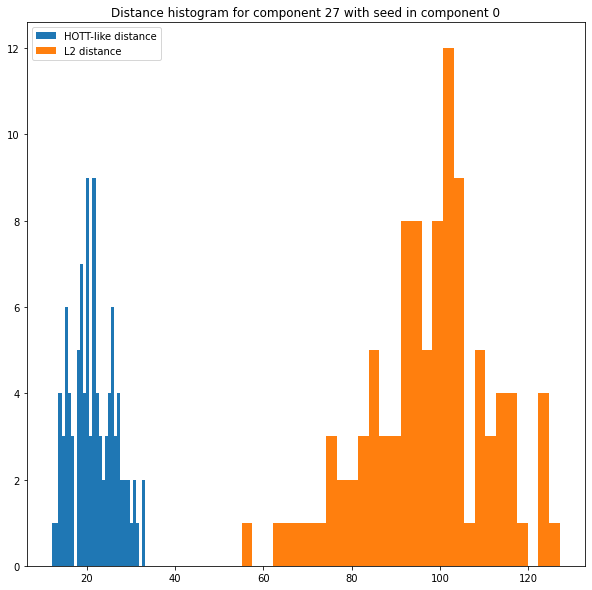

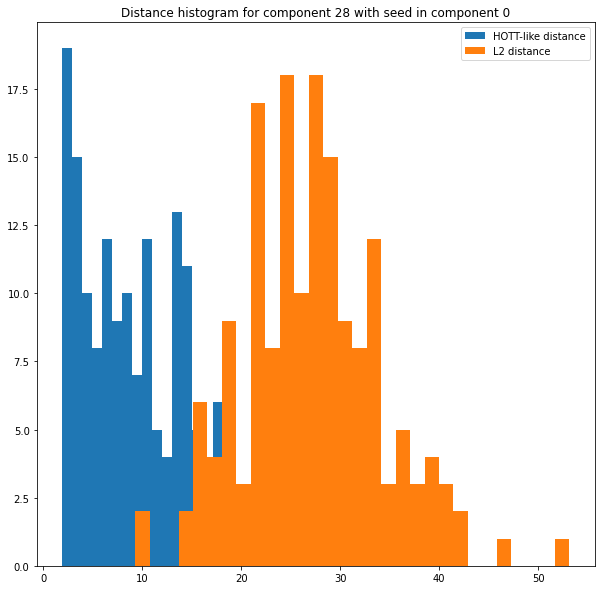

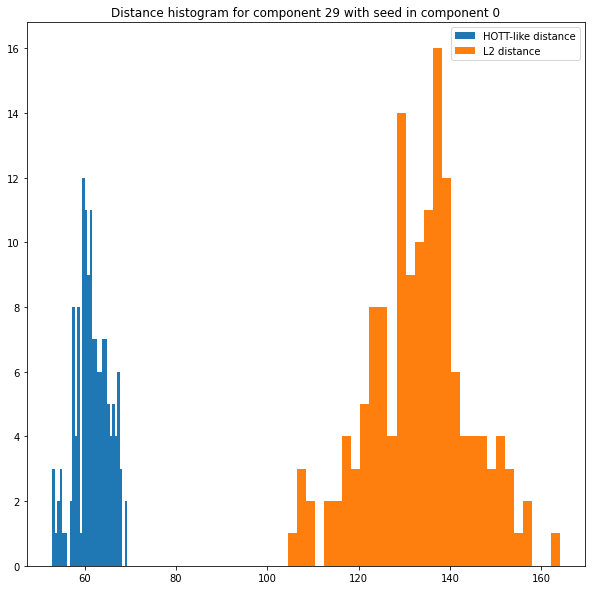

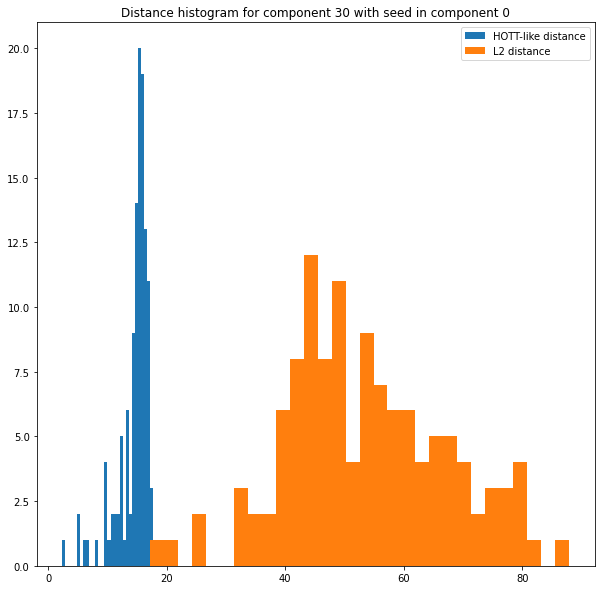

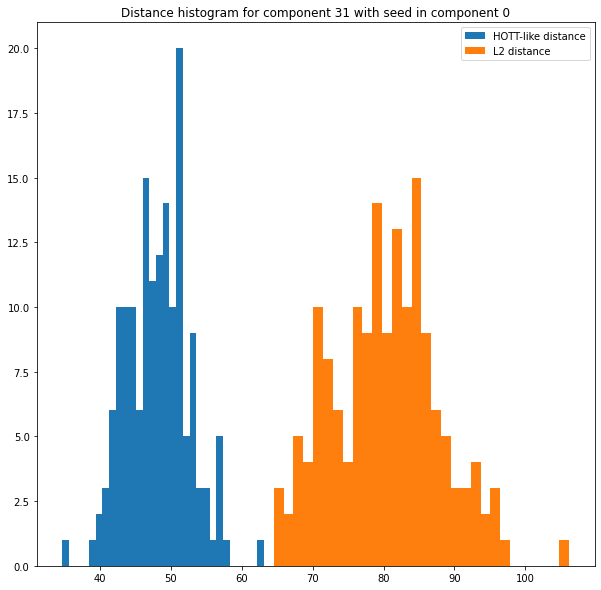

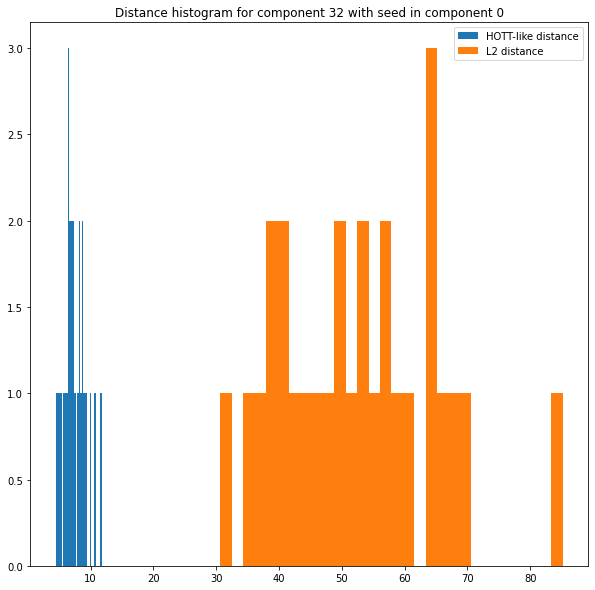

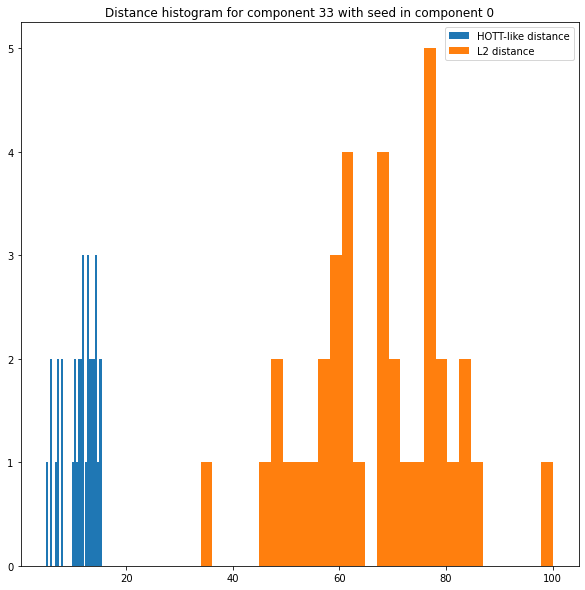

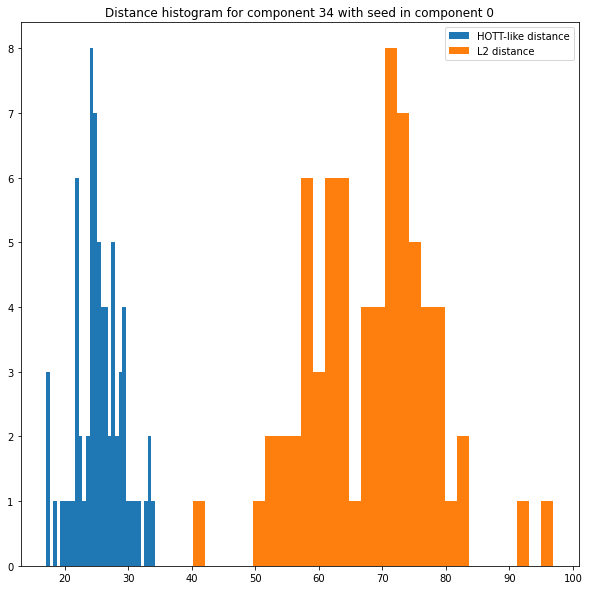

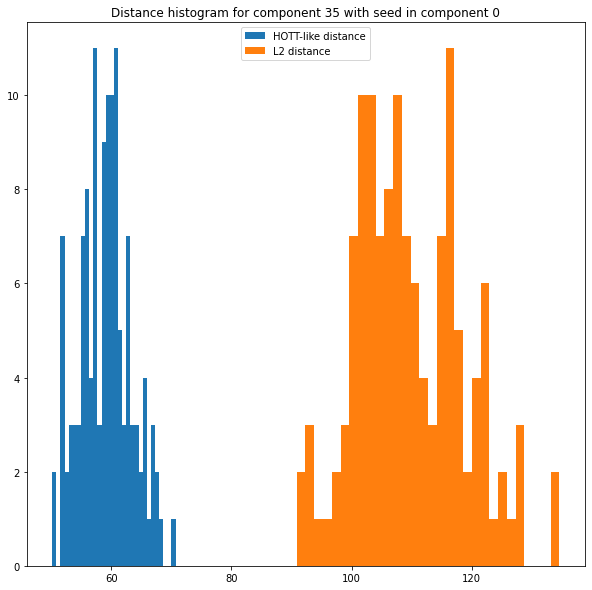

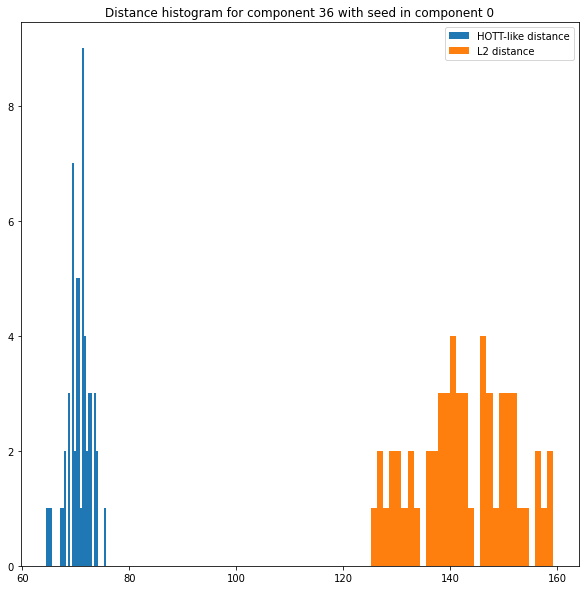

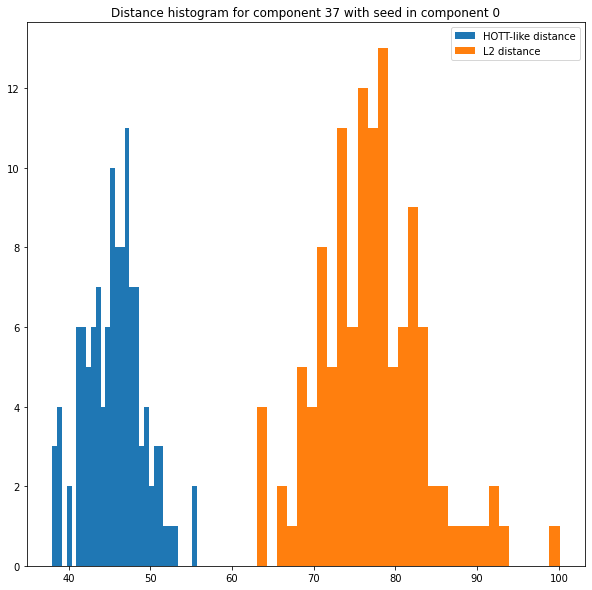

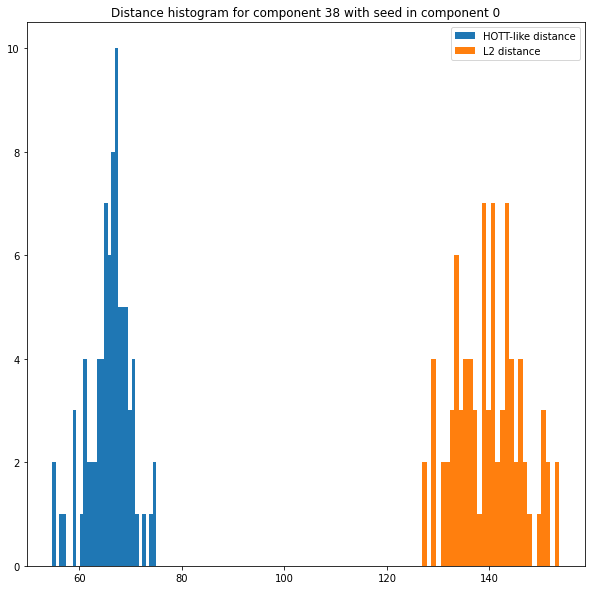

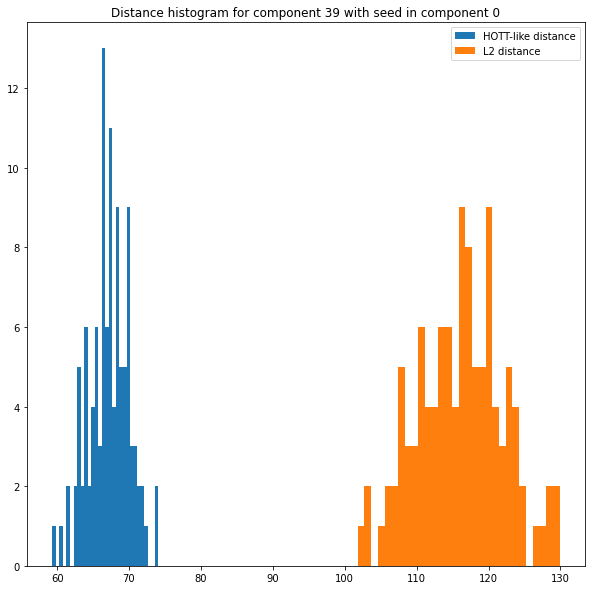

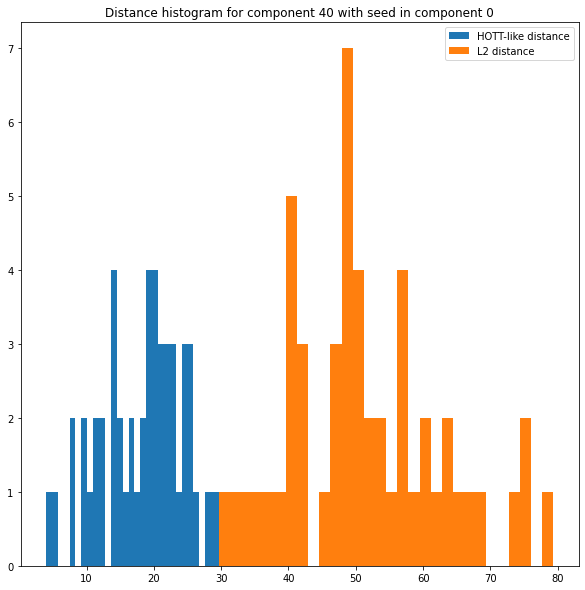

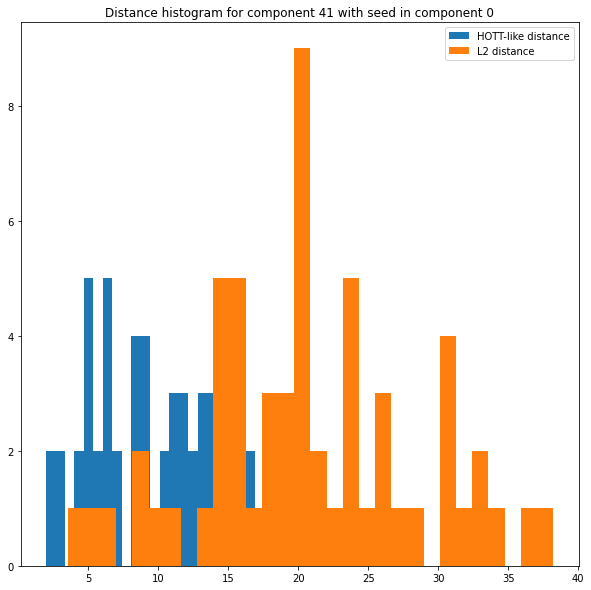

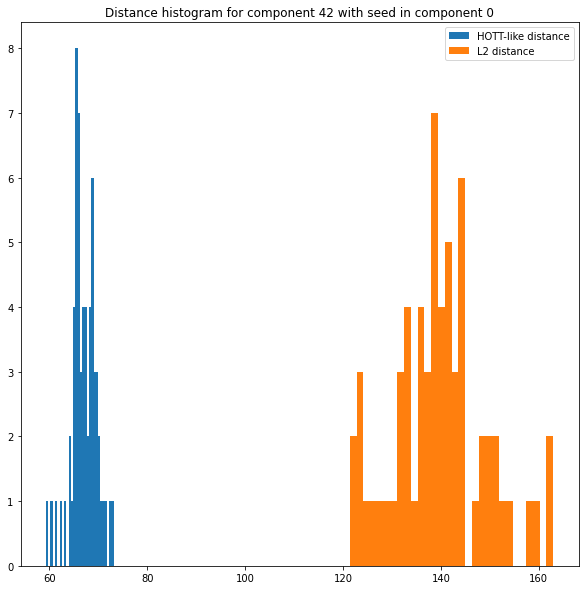

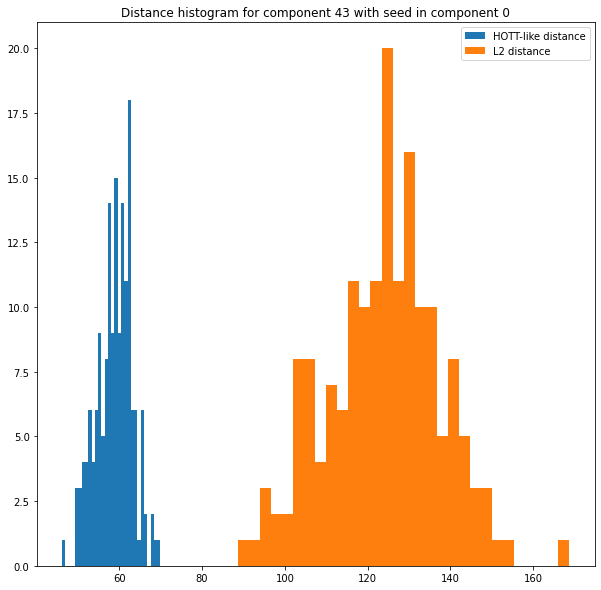

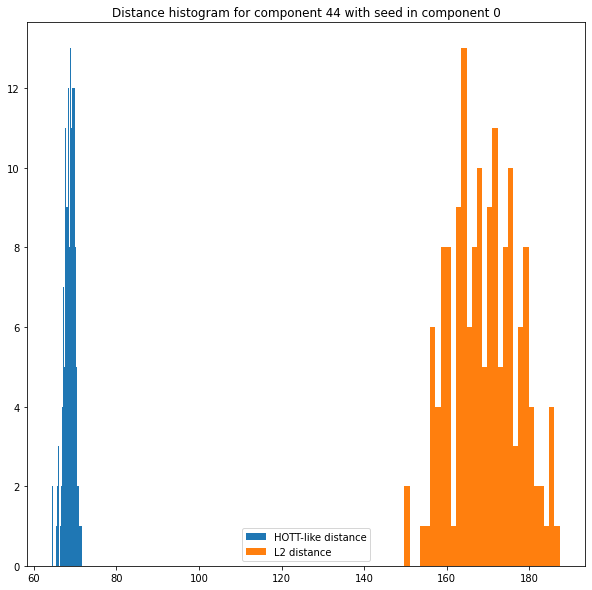

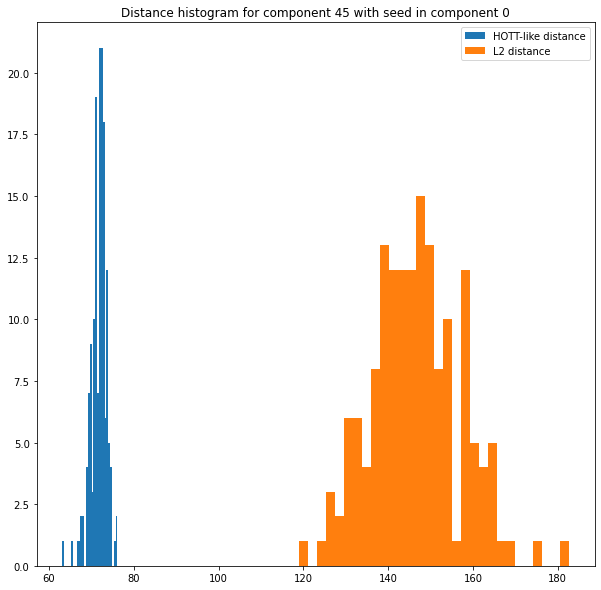

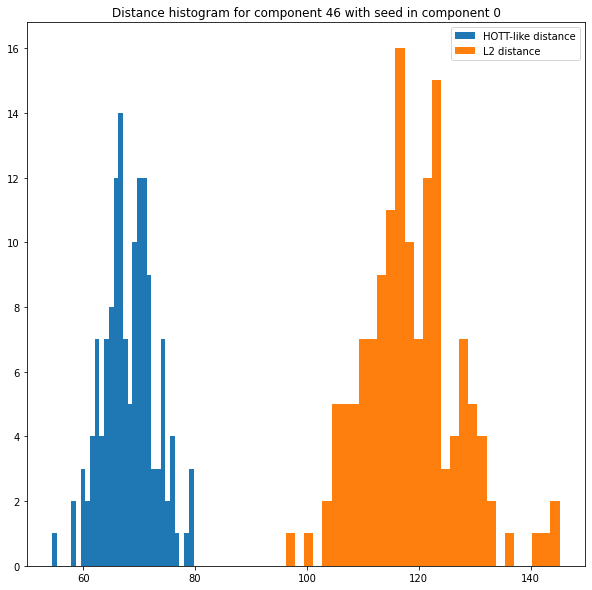

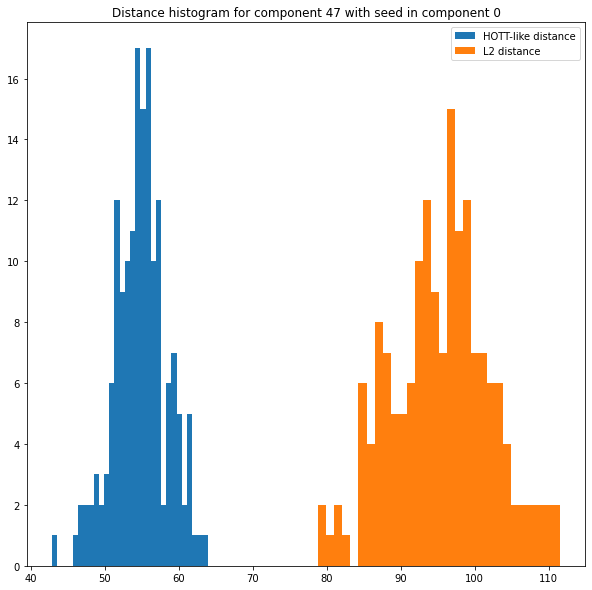

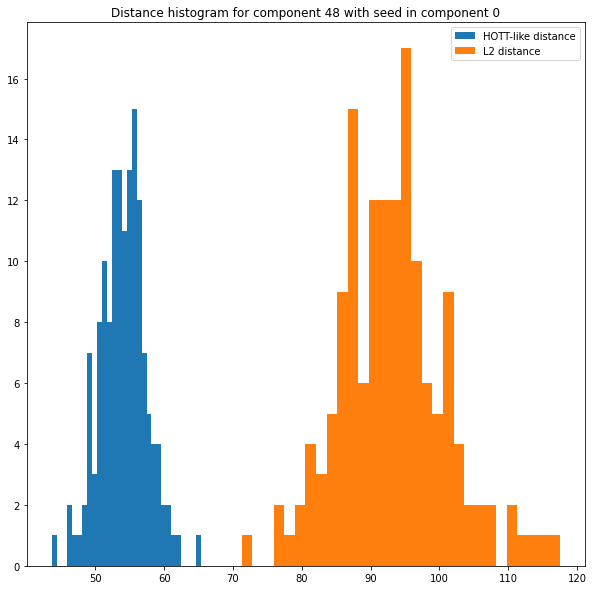

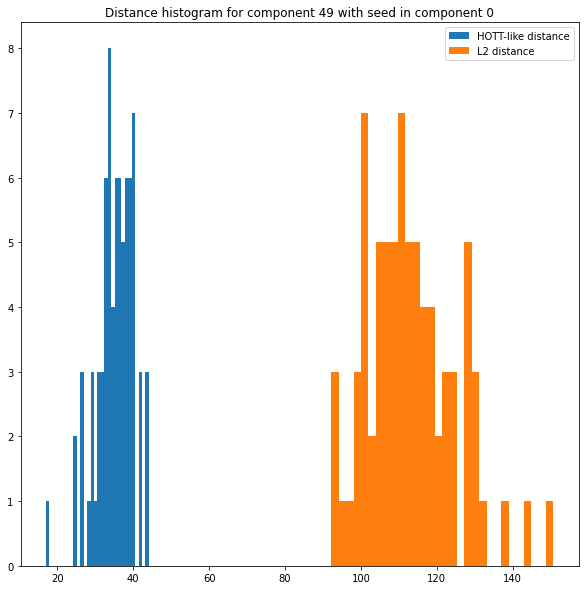

In [ ]:
for i, dists in enumerate(w2_dists_by_label):
  ax = plt.axes()
  ax.set_title(f'Distance histogram for component {i} with seed in component {labels[seed]}')
  ax.hist(dists,bins=30, label='HOTT-like distance')
  ax.hist(l2_dists_by_label[i],bins=30, label='L2 distance')
  ax.legend()
  plt.show()